In [ ]:
!nvidia-smi

Fri Feb 25 09:32:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Libraries

In [ ]:
import numpy as np
import os

In [ ]:
x_train = np.load(os.path.join(os.getcwd(), "x_train.npy"))
y_train = np.load(os.path.join(os.getcwd(), "y_train.npy"))
x_test = np.load(os.path.join(os.getcwd(), "x_test.npy"))
y_test = np.load(os.path.join(os.getcwd(), "y_test.npy"))

In [ ]:
x_train.shape

(142, 30, 63)

**Models**

In [ ]:
import tensorflow as tf

In [ ]:
inp_shape = x_train.shape[1:]
print(inp_shape)

(30, 63)


In [ ]:
out_shape = y_train.shape[-1]

In [ ]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(units=128, return_sequences=True, activation="relu", kernel_initializer="he_uniform", input_shape=(30, 63)))
model.add(tf.keras.layers.Dropout(rate=0.2))

model.add(tf.keras.layers.LSTM(units=128, return_sequences=True, kernel_initializer="he_uniform", activation="relu"))
model.add(tf.keras.layers.Dropout(rate=0.2))

model.add(tf.keras.layers.LSTM(units=128, return_sequences=False, kernel_initializer="he_uniform", activation="relu"))
model.add(tf.keras.layers.Dropout(rate=0.2))

model.add(tf.keras.layers.Dense(units=128, activation="relu"))
model.add(tf.keras.layers.Dropout(rate=0.2))

model.add(tf.keras.layers.Dense(units=64, activation="relu"))
model.add(tf.keras.layers.Dense(units=5, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 128)           98304     
                                                                 
 dropout_4 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_5 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 128)              

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("model.h5",
                             monitor="loss",
                             mode="min",
                             save_best_only=True,
                             verbose = 1)

earlystop = tf.keras.callbacks.EarlyStopping(monitor="loss",
                         min_delta=0,
                         patience=8,
                         verbose=1,
                         restore_best_weights=True)

In [ ]:
log_dir = os.path.join('Logs')
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,
          epochs=100, 
          callbacks=[tb_callback, earlystop, checkpoint])

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 1.6090 - accuracy: 0.1901
Epoch 1: loss improved from inf to 1.60900, saving model to model.h5
5/5 [==============================] - 5s 207ms/step - loss: 1.6090 - accuracy: 0.1901
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 1.3355 - accuracy: 0.3662
Epoch 2: loss improved from 1.60900 to 1.33548, saving model to model.h5
5/5 [==============================] - 1s 209ms/step - loss: 1.3355 - accuracy: 0.3662
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 1.0206 - accuracy: 0.5915
Epoch 3: loss improved from 1.33548 to 1.02059, saving model to model.h5
5/5 [==============================] - 1s 209ms/step - loss: 1.0206 - accuracy: 0.5915
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.8857 - accuracy: 0.6620
Epoch 4: loss improved from 1.02059 to 0.88570, saving model to model.h5
5/5 [==============================] - 1s 201ms/step - loss: 0.8857 - accuracy:

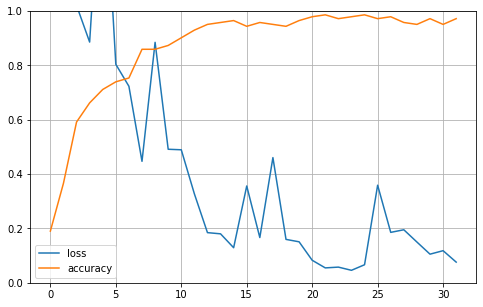

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
import tensorflow as tf

lstm = tf.keras.models.load_model("model.h5")

In [ ]:
res = lstm.predict(x_test)

In [ ]:
actions = np.array(['Up', 'Down', 'Right', 'Left', 'Stop'])

In [ ]:
for idx in range(8):
  print(actions[np.argmax(y_test[idx])], actions[np.argmax(res[idx])])

Right Right
Down Down
Up Stop
Left Left
Down Down
Right Right
Left Left
Up Up


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
yhat = lstm.predict(x_test)

ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
accuracy_score(ytrue, yhat)

0.875

In [ ]:
import tensorflow as tf

model =tf.keras.models.load_model("model.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter = True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()
open("model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp4qdp_gid/assets


INFO:tensorflow:Assets written to: /tmp/tmp4qdp_gid/assets


427312